<a href="https://colab.research.google.com/github/PGCodehub/BasicNeworks/blob/master/Image_Classifier__Food101_Challange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Thanks for giving this opputunity , I really learned a lot just through this Challange **

Able to achive a accuaracy of 87.9% on test set , Thanks 

#Intial Code for colab 

In [0]:
#PYDRIVE AND GOOGLE AUTHENTICATION CELL

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driveauth = GoogleDrive(gauth)

In [5]:
#For Mounting the Google Drive to directly use
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Import fast ai library 

In [6]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import os

from tqdm import tqdm


#Information about FoodAI Dataset



The challange was to Classifiy Food images , [The FOOD101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)  dataset was used.

>The data set of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images.

>On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels

>All images were rescaled to have a maximum side length of 512 pixels.

From this dataset Folders was created with format of 

``` path\
  train\
    class1\
    class2\
    ...
  test\
    class1\
    class2\
    ...```


* So the Data was rearranged to have food101 has train valid and test subfolders each with 101 calsses  of a toatl 60600 images , 15150 images and 25250 respectively 

* At the end  food101two  has train valid  subfolders each with 101 calsses  of a toatl 75750 images and 25250 respectively for final training section

#Data Imports

In [0]:
%cd /content/gdrive/My Drive
!ls


In [0]:
%cd /content
!ls


/content
adc.json  data	food-101  food101two  gdrive  models


In [0]:
!tar -xzf  '/content/gdrive/My Drive/food101finaldata.tar.gz'


In [0]:
%cd /content/food101/valid/
!ls

In [0]:
from PIL import Image

In [0]:
pathto =  '/content/food101/test/apple_pie/2446133.jpg'

imag = Image.open(pathto)
    
imag.size

(512, 512)

In [0]:
path =  '/content/food101'


In [0]:
bs = 64


# Exploratory Data Analysis


>Intially ImageDatabuch was created

In [0]:
path = '/content/food101two'

In [0]:
bs = 64


In [0]:
dataexp = ImageDataBunch.from_folder(path , ds_tfms=get_transforms(), size=224 ,  bs=bs).normalize(imagenet_stats)

In [13]:
print(dataexp.classes)
len(dataexp.classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

101

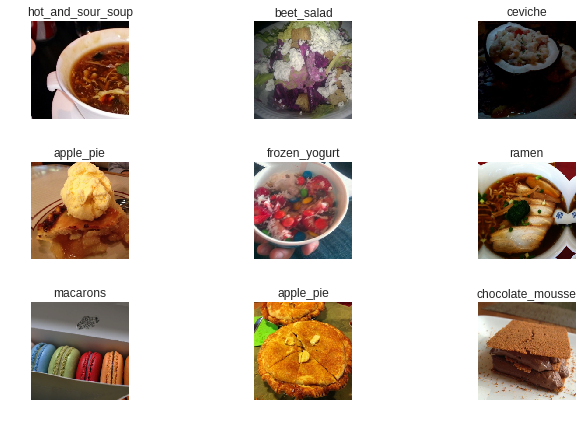

In [19]:
dataexp.show_batch(rows=3, figsize=(10,6))


Food-101 is a challenging dataset consisting of 101,000 images of 101 different food classes. Taking a look at some of the images, we can see why models may struggle to get good results.


The creators of the dataset left the training images deliberately uncleaned, so there are a number of mislabelled images, and as we can see, a large range in brightness / colour saturation. More fundamentally, however, it’s clear that no two bread puddings are quite alike (or at all alike it seems). Classifying images with such high intraclass variation is hard.

If our model is to perform well “in the wild”, it needs to be able to handle these issues: real, non-professional photos of food aren’t going to be of uniform size and are unlikely to have perfect lighting or framing.



Present SoTa models like InceptionV3 has a top1 % accuracy of 88.8% and

other unqinue architectures has achieved a litttle higer accuracy of 990% 

With Rstnet model most models whose accuracy is above 90% has used 200 layers or more So to get that level of accuary on Restnet50 we need to use wide varaiety of  regularisations 

#Process Went into Creating a  image Classifier 

After understanding the data i decided to  go through following steps


**1. **  The first setp for me is to train the network  , i decided to go with  fast ai library , one main reason for this chossing is use to ONE CYCLE POLICY 



> > ONE CYCLE POLICY :  It refers to usage of  idea given in [paper](https://arxiv.org/abs/1803.09820) .The idea is to run to do a cycle with two steps of equal lengths, one going from a lower learning rate to a higher one than go back to the minimum and is  further explained [here](https://sgugger.github.io/the-1cycle-policy.html)




> During experiments it  is seen that the during the middle of the cycle, the high learning rates will act as regularization method, and keep the network from overfitting. They will prevent the model to land in a steep area of the loss function, preferring to find a minimum that is flatter.

> Then the last part of the training, with descending learning rates up until annihilation will allow us to go inside a steeper local minimum inside that smoother part.



##Model chosen


2. The challange was to use Resnet50 or lower layered Network to train a model for image classification



> So i used a Pretrained Resnet50  as basic network and created a model with fast ai method
 >>** learn64 = create_cnn(data, models.resnet50, metrics=accuracy)**
 


> THis method takes Resnet50 and replaces the final fully connected layer with custom head so that output layers is set according to no of Classes in dataset



##Why i choose to train model with first image size of 64 then 150 , 224,300

2. During intial expermentaion the first image size of 224 by 224 was used to train the model but after several epochs the model went upto 75% acuuracy and started to overfit to the data 


> >This could be of folowing reasons could be that 


 >>>  *   custom head was not enough layers, So the different Custom head with more layers was used but didnot change the results
 >>>  *   Second reason could be that as we are using **1cycle Policy** , it works efficently when run for several epochs , but due to gpu constraints on colab i only can run max of 3 to 4 epochs and due to which overfitting regularisation of  **1cycle Policy**  is not taking effect at higher accuracy
 
 >>So i chose to use another regularisation method of starting train with low image sizes and gradually improving sizes and train , This expermentally proven to be good regularizer 




>So  i choose to train model with first image size of 64 then 150 , 224,300


#The Training Process

* As explained earliear it was chossen to test by running by taking image size of 64 , 150 , 224 ,300


* Model is intailly trained with only with 60600 images (101 classes , so each 600) and valid loss and acccuracy were calculated on 15150 images 

## General priciples and steps of training 


###Train custom head with optimal lr
* Intially the model was trained on 64 imagesize, increasing to 150 , 224 , 300 

* The First step is to create a  model and only train head part(Fully connected layers )

* The second step is to find optimal learning rate through lrfind fn

![Freeze](https://drive.google.com/uc?export=view&id=1JYUnEoOEpGvSvK4ti2iJvTXs_XnN5yaH)




### Training with one cycle policy

* Then the model is trained taking that lr and deseried epochs using fit_one_cycle

>> * Fit_one_cycle trains model based on one cycle policy where lr and momentum takes as below image


![Freeze](https://drive.google.com/uc?export=view&id=1oXZ5T3BZT8oyymht1IgrsfNHeqbWqBdf)
![alt text](https://)


###Train unfrozen model with diiferential lr

* Now after the model is trained the model is unfrozen ,so that all layers are trained 

* but here we train the  model with differential laerning rates such that intail layers has very low lr as they need not learn much than pretrained filters , where as later layers  learn more 

* the lrfind is used and max lr range is choosen 

![Freeze](https://drive.google.com/uc?export=view&id=1aUyJFN207D4T-GjTIhR-HO-FcYOrg1i3)

and learning rate is chosen such that lr is times less than where loss start to increase


* But in certain cases later in higher image sizes i choose  a higher lr close to wher losses strart to increase as 

![Freeze](https://drive.google.com/uc?export=view&id=1X-6J-Q6o4FDBUTTZ2fBvu_sb8RrVwww0)


THe main reason for this to get this loss curve 



>>Here the learning rate is starts increasing and then drecreases

![Freeze](https://drive.google.com/uc?export=view&id=18cgfN1YMgSiyehD2J9ZfuULYkxJ3VJr9)


* This is very important because , if our model is stuck in steep minimum rather than flat minimum , by slowly increasing learning rate the model comes out of steep minimum and settles at flat minimum in second part of cycle when lr starts decreasing





#Train with Image Size 64 x 64

Training with 64 x 64 image size

In [0]:
#The first learner will be trained with 64

##DataBunch


* The databunch is created to run through the learner of fastai library

* The ImageDataBunch creates batches of images with batch size specified as bs which is 64 here 

* The Image size Choosen was 64 by 64 

In [0]:
data = ImageDataBunch.from_folder(path , ds_tfms=get_transforms(), size=64 ,  bs=bs).normalize(imagenet_stats)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

(101, 101)

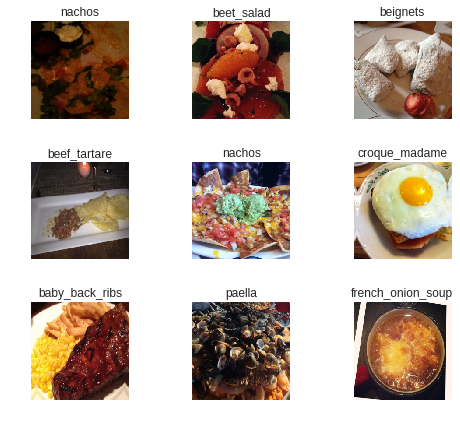

In [0]:
data.show_batch(rows=3, figsize=(7,6))
print(data.classes)
len(data.classes),data.c

## Training of model 


* The resnet model with custom head is created using 

>>**create_cnn(data, models.resnet50, metrics=accuracy)**


and metrices i chose was accuracy

In [0]:
learn64 = create_cnn(data, models.resnet50, metrics=accuracy)

##About learning rate finder 

Our first step is to find the best learning rate , to do so a learning rate finder lrfind() fn was used 

* The way learing rate finder was discribed in [Cyclical Learning Rates for Training Neural Networks
](https://arxiv.org/abs/1506.01186) and  

* it works as we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03


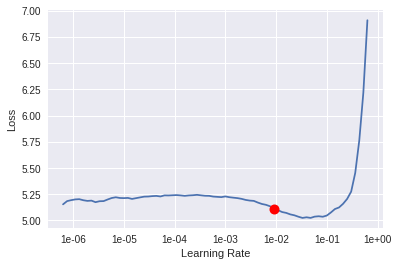

In [0]:
learn64.lr_find()
learn64.recorder.plot()

The learning rate i choose is 1e-02 which is where we see a steep drop in loss

In [0]:
learn64.fit_one_cycle(2 , 1e-02)

epoch,train_loss,valid_loss,accuracy
1,3.090273,2.991984,0.281386
2,2.526513,2.364404,0.413333


In [0]:
learn64.save('stage64-1-50')

In [0]:
learn64.load('stage64-1-50')

After training the model is unfrozen meaning not all the parameters in the model will be trained not just  custom head 



In [0]:
learn64.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


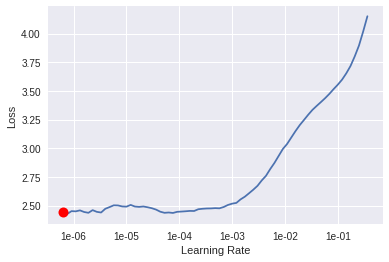

In [0]:
learn64.lr_find()
learn64.recorder.plot()

*  The learning rate Here passed in the choosen ten times less the learning rate when loss starts to spike in lrfind plot

In [0]:
learn64.fit_one_cycle(3, max_lr=slice(1e-05,(1e-04)/2))

epoch,train_loss,valid_loss,accuracy
1,2.420135,2.276060,0.430033
2,2.280135,2.165410,0.459406
3,2.162263,2.144173,0.463828


In [0]:
learn64.save('stage64-2-50')

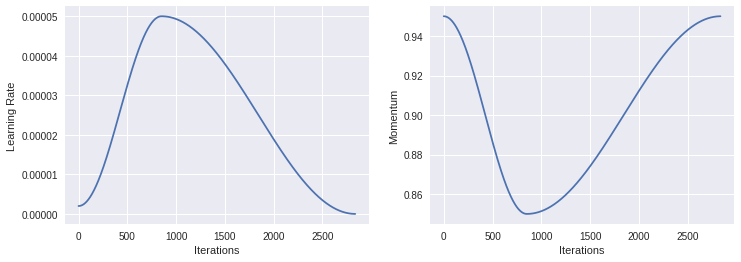

In [0]:
learn64.recorder.plot_lr(show_moms=True)


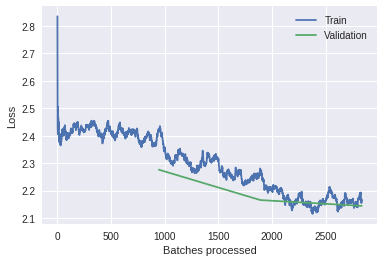

In [0]:
learn64.recorder.plot_losses()

In [0]:
def savecheckpoint(filename):
    modelcheckpoint = { 
                   'state_Dict': learn64.model.state_dict(),
                   
                   }
    
    
    torch.save(modelcheckpoint, filename)
    print("The model is saved in {} file..".format(filename))

In [0]:
filename = 'CHECKPOINT64.pth'
savecheckpoint(filename)

The model is saved in CHECKPOINT64.pth file..


In [0]:
f = "CHECKPOINT64.pth"
uploaded = driveauth.CreateFile()
uploaded.SetContentFile(f)
uploaded.Upload()
print('Uploaded file %s with ID %s'%(f, uploaded.get('id')))

Uploaded file CHECKPOINT64.pth with ID 1A8kO7lDww7wQDJ0HG12k1t3mDn-H9lMT


#Train with Image size  150 x 150

In [0]:
#The first learner will be trained with 150 image size

In [0]:
data = ImageDataBunch.from_folder(path , ds_tfms=get_transforms(), size=150 ,  bs=bs).normalize(imagenet_stats)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

(101, 101)

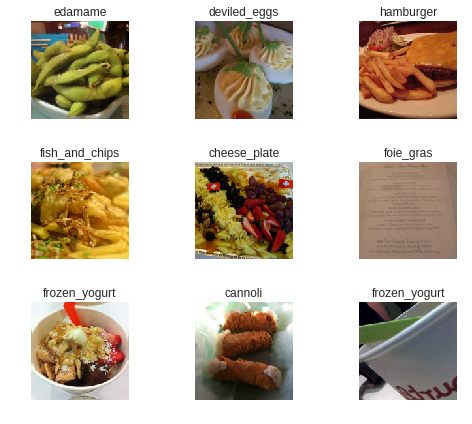

In [0]:
data.show_batch(rows=3, figsize=(7,6))
print(data.classes)
len(data.classes),data.c

In [0]:
learn150 = create_cnn(data, models.resnet50, metrics=accuracy)

In [0]:
learn150.load('stage64-2-50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


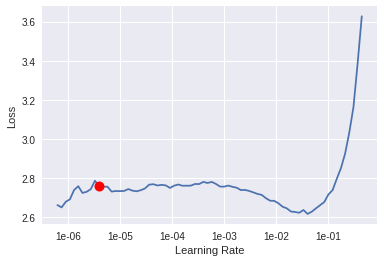

In [0]:
learn150.lr_find()
learn150.recorder.plot()

In [0]:
learn150.fit_one_cycle(2 , 1e-03)

In [0]:
epoch	train_loss	valid_loss	accuracy
1	1.843744	1.685161	0.570165
2	1.680704	1.597817	0.588317

In [0]:
learn150.save('stage150-1-50')

In [0]:
learn150.load('stage150-1-50')

In [0]:
 Acurracy(learn150.model)

Calculating Acuracy:
Accuracy of the network on the 15150 test images: 53.23432343234323%...


53.23432343234323

In [0]:
learn150.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


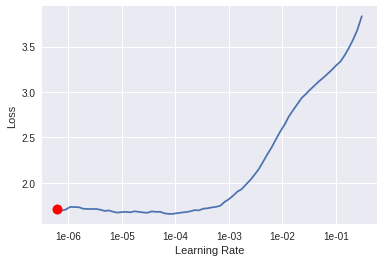

In [0]:
learn150.lr_find()
learn150.recorder.plot()

In [0]:
learn150.fit_one_cycle(3, max_lr=slice((1e-06),(1e-04)/3))

epoch,train_loss,valid_loss,accuracy
1,1.668923,1.547343,0.601056
2,1.556652,1.477931,0.619340
3,1.512692,1.465474,0.622838


In [0]:
learn150.save('stage150-2-50')

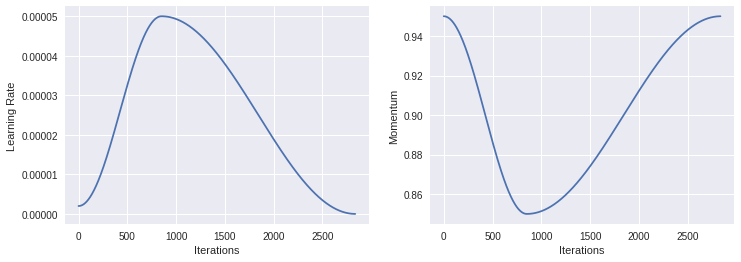

In [0]:
learn150.recorder.plot_lr(show_moms=True)


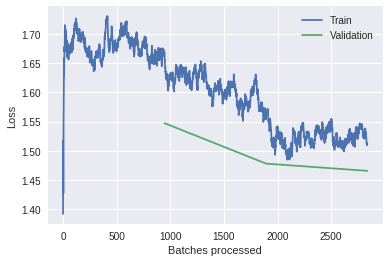

In [0]:
learn150.recorder.plot_losses()

In [0]:
def savecheckpoint(filename):
    modelcheckpoint = { 
                   'state_Dict': learn150.model.state_dict(),
                   
                   }
    
    
    torch.save(modelcheckpoint, filename)
    print("The model is saved in {} file..".format(filename))

In [0]:
filename = 'CHECKPOINT150.pth'
savecheckpoint(filename)

The model is saved in CHECKPOINT150.pth file..


In [0]:
f = "CHECKPOINT150.pth"
uploaded = driveauth.CreateFile()
uploaded.SetContentFile(f)
uploaded.Upload()
print('Uploaded file %s with ID %s'%(f, uploaded.get('id')))

Uploaded file CHECKPOINT150.pth with ID 1qZ-H-bAEvMm4BbypXg43RcV-CCjaHPt6


#Train with Image size 224 x 224

In [0]:
data = ImageDataBunch.from_folder(path , ds_tfms=get_transforms(), size=224 ,  bs=bs).normalize(imagenet_stats)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

(101, 101)

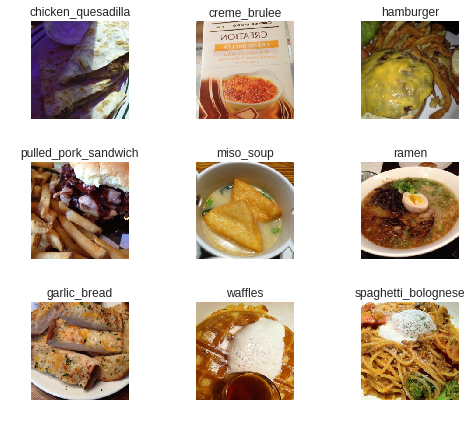

In [0]:
data.show_batch(rows=3, figsize=(7,6))
print(data.classes)
len(data.classes),data.c

In [0]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [0]:
learn.load('stage150-2-50')

In [0]:
learn.model.train()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


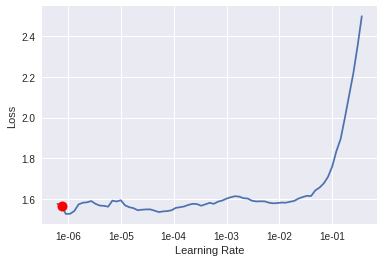

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2 , 1e-03/3)

epoch,train_loss,valid_loss,accuracy
1,1.481085,1.386683,0.639010
2,1.432738,1.359249,0.645083


In [0]:
learn.save('stage224-1-50')

In [0]:
learn.load('stage224-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (60600 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bread_pudding,bread_pudding,bread_pudding,bread_pudding,bread_pudding
Path: /content/content/food101;

Valid: LabelList (15150 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bread_pudding,bread_pudding,bread_pudding,bread_pudding,bread_pudding
Path: /content/content/food101;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


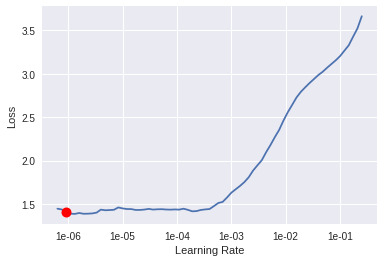

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:

learn.fit_one_cycle(3, max_lr=slice(1e-05,1e-03))

epoch,train_loss,valid_loss,accuracy
1,1.574624,1.481214,0.613993
2,1.220775,1.128879,0.702376
3,1.001680,1.016449,0.733531


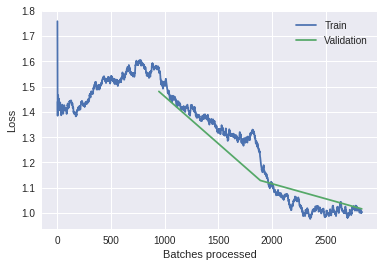

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage224-2-50')

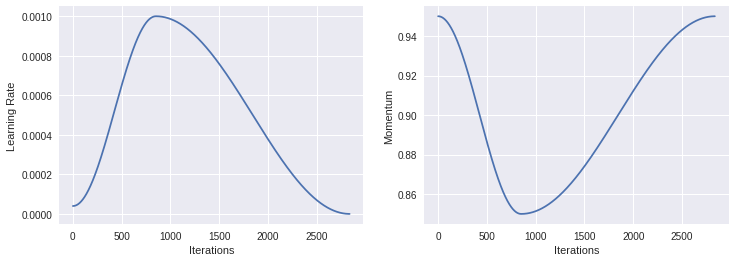

In [0]:
learn.recorder.plot_lr(show_moms=True)


In [0]:
def savecheckpoint(filename):
    modelcheckpoint = { 
                   'state_Dict': learn.model.state_dict(),
                   
                   }
    
    
#'optimizer_state_dict':optimizer.state_dict(),
    torch.save(modelcheckpoint, filename)
    print("The model is saved in {} file..".format(filename))

In [0]:
filename = 'CHECKPOINT224.pth'
savecheckpoint(filename)

The model is saved in CHECKPOINT224.pth file..


In [0]:
f = "CHECKPOINT224.pth"
uploaded = driveauth.CreateFile()
uploaded.SetContentFile(f)
uploaded.Upload()
print('Uploaded file %s with ID %s'%(f, uploaded.get('id')))

Uploaded file CHECKPOINT224.pth with ID 1GLgw5VFejPFqxSS-XYJ1J1oKdQYIlhqd


#Train to Image size 300 x 300

Here the Unfrozen model is directly trained 

In [0]:
#changing imagesize to 300 and train again this will give make model less overfit

In [0]:
path = '/content/food101'

In [0]:
bs300 = 32

In [0]:
data300 = ImageDataBunch.from_folder(path , ds_tfms=get_transforms(), size=300 ,  bs=bs300).normalize(imagenet_stats)

In [0]:
learn300 = create_cnn(data300, models.resnet50, metrics=accuracy)

In [0]:
learn300.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


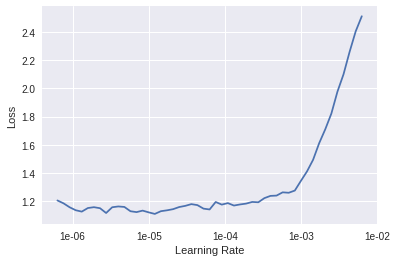

In [0]:
learn300.lr_find()
learn300.recorder.plot()

In [0]:
learn300.fit_one_cycle(3, max_lr=slice(1e-05,(1e-03)/5))

epoch,train_loss,valid_loss,accuracy,time
1,1.260951,1.139620,0.699868,48:50
2,1.088159,0.952533,0.750957,48:32
3,0.849952,0.875805,0.768317,48:34


In [0]:
learn300.save('stage-3-50')

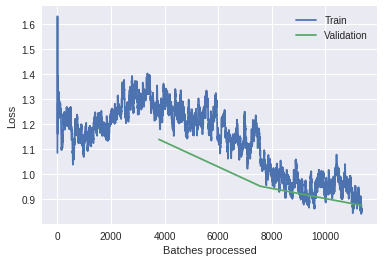

In [0]:
learn300.recorder.plot_losses()

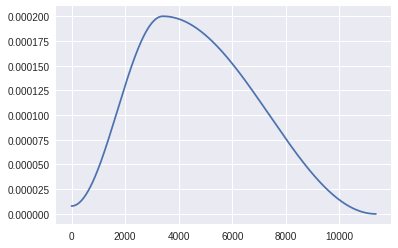

In [0]:
learn300.recorder.plot_lr()

In [0]:
def savecheckpoint(filename):
    modelcheckpoint = { 
                   'state_Dict': learn300.model.state_dict(),
                   
                   }
    
    
#'optimizer_state_dict':optimizer.state_dict(),
    torch.save(modelcheckpoint, filename)
    print("The model is saved in {} file..".format(filename))

In [0]:
filename = 'CHECKPOINT_300_l.pth'
savecheckpoint(filename)

The model is saved in CHECKPOINT_300_p.pth file..


In [0]:
f = "CHECKPOINT_300_l.pth"
uploaded = driveauth.CreateFile()
uploaded.SetContentFile(f)
uploaded.Upload()
print('Uploaded file %s with ID %s'%(f, uploaded.get('id')))

Uploaded file CHECKPOINT_300_p.pth with ID 1RbDpIuvZVvgfpB46q4I33jSun2jrSl8u


#Tain the model with complete Train dataset

>*with image size of 300 x 300*

### Finally training

> Here the model is trained on full dataset

As you can see that previous model we trained as reached 

```

epoch	train_loss	valid_loss	accuracy	

3	0.849952	0.875805	0.768317	
``` 
 
A loss of  0.84 on train data and 0.87 on valid data After i tried futher training and but acuuracy didnot increase and model start to overfit , and TTA() on test set didnot show any improvemnet

* It was clear that some images that were seperated as validation set has inforamtion or new images that were need to made to single training set and need to be trained

###Final model dataset 

* Model is intailly trained with only with 75750 images (101 classes , so each 750) and valid loss and acccuracy were calculated on 25250 images which is a test set 

In [0]:
path = '/content/food101two'

In [0]:
bsfinal = 16

In [0]:
datafinal = ImageDataBunch.from_folder(path , ds_tfms=get_transforms(), size=300 ,  bs=bsfinal).normalize(imagenet_stats)

In [0]:
learnfinal = create_cnn(datafinal, models.resnet50, metrics=accuracy)

In [0]:
learnfinal

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
waffles,waffles,waffles,waffles,waffles
Path: /content/food101two;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
waffles,waffles,waffles,waffles,waffles
Path: /content/food101two;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [0]:
learnfinal.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


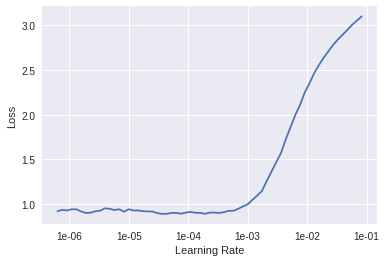

In [0]:
learnfinal.lr_find()
learnfinal.recorder.plot()

In [0]:
learnfinal.fit_one_cycle(2, max_lr=slice(1e-05,(1e-03)/5))

epoch,train_loss,valid_loss,accuracy,time
1,0.966990,0.663699,0.816198,56:54
2,0.805377,0.557445,0.845822,56:51


In [0]:
learnfinal.save('stage-final')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


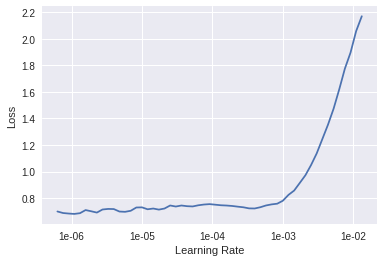

In [0]:
learnfinal.lr_find()
learnfinal.recorder.plot()

In [0]:
learnfinal.fit_one_cycle(3, max_lr=slice(1e-05,(1e-03)/5))

epoch,train_loss,valid_loss,accuracy,time
1,0.902392,0.655947,0.816673,56:30
2,0.774608,0.556064,0.843921,56:35
3,0.654403,0.512915,0.856277,56:34


In [0]:
learnfinal.save('stage-final-2')

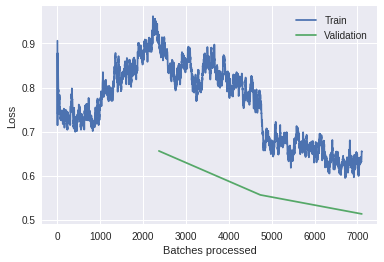

In [0]:
learnfinal.recorder.plot_losses()

In [0]:
lod_preds, y = learnfinal.TTA()

In [0]:
probs = np.exp(lod_preds)

In [0]:
accuracy(probs, y)

tensor(0.8663)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


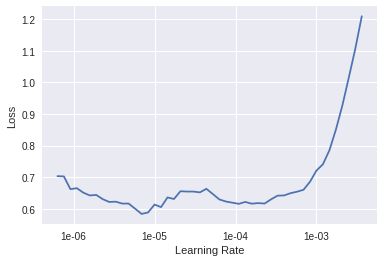

In [0]:
learnfinal.lr_find()
learnfinal.recorder.plot()

In [0]:
learnfinal.fit_one_cycle(3, max_lr=slice(1e-05,(1e-04)/5))

epoch,train_loss,valid_loss,accuracy,time
1,0.624587,0.492198,0.859723,59:05
2,0.607343,0.469089,0.867208,59:04
3,0.545653,0.456867,0.871287,58:58


In [0]:
learnfinal.save('finalsub')

#Results

In [0]:
path = '/content/food101two'

In [0]:
bsfinal = 128

In [0]:
datafinal = ImageDataBunch.from_folder(path , ds_tfms=get_transforms(), size=300 ,  bs=bsfinal).normalize(imagenet_stats)

In [12]:
learnfinal = create_cnn(datafinal, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 98254388.69it/s]


In [24]:
learnfinal.load('finalsub')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
omelette,omelette,omelette,omelette,omelette
Path: /content/food101two;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
omelette,omelette,omelette,omelette,omelette
Path: /content/food101two;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum

## Final Accuracy on test set


For Final accuracy Test Time Augmentation iis used .

* **Test TIme Augmentation** : This technique is used to get final accuracy where images in test set are taken in 8 different augemtaion and loss is calculated and averaged among 8 .Since these images  are taken cover different parts of image with different augmentaion.

The prediction becomes more acuuate,Thus TTA( ) was used.

In [0]:
log_preds, y = learnfinal.TTA()

In [0]:
probs = np.exp(log_preds)

In [0]:
accuracy(probs, y)

tensor(0.8791)

**Finally model trained was achieved an accuaracy of 87.91 which crosses the Given challange **

*  **Hence Challange Achieved** (Hope so)

###Futher Result Analysis

In [0]:
interp = ClassificationInterpretation.from_learner(learnfinal)


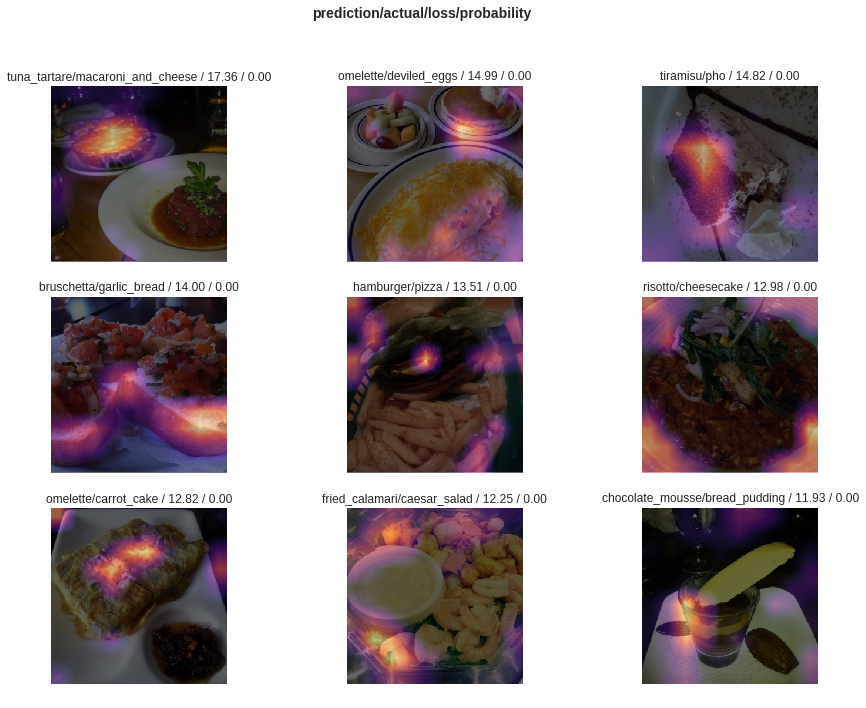

In [26]:
interp.plot_top_losses(9, figsize=(15,11))


##

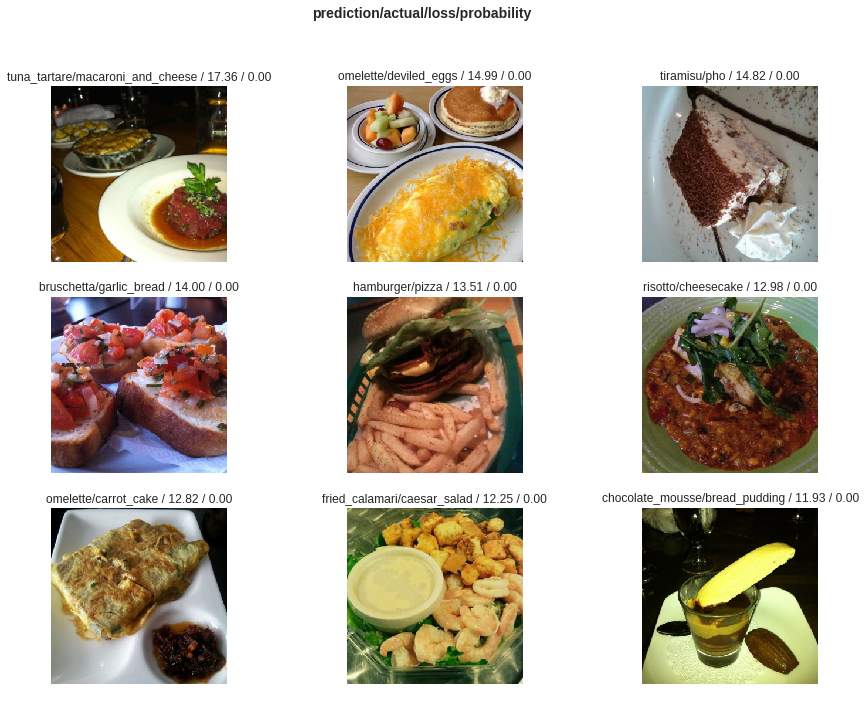

In [27]:
interp.plot_top_losses(9, figsize=(15,11), heatmap = False)


###Interpertaion 

* The main reasons for the loss are:

>As we can clearly see that all the top loss images has multiple objects that overlap with other catagories in food 101 dataset

> Second is wrong lables , 

>>for eg in first image in last row was predicted as omelete as it is but it mislabed as carrot cake ,
and second image in second row was a hamburger but mislabel as pizza  and several more


**This show that loss of 0.55 on test set majorly due to wrong labels and would have much better accuracy on good test data**

And seeing from the heat map the even with multiple objects in image the classifer was able to focus manly on highest probable

In [33]:
interp.most_confused(min_val = 2)

[('steak', 'filet_mignon', 46),
 ('filet_mignon', 'steak', 29),
 ('chocolate_mousse', 'chocolate_cake', 22),
 ('chocolate_cake', 'chocolate_mousse', 21),
 ('prime_rib', 'steak', 21),
 ('tuna_tartare', 'beef_tartare', 20),
 ('pork_chop', 'grilled_salmon', 18),
 ('pork_chop', 'steak', 18),
 ('beef_tartare', 'tuna_tartare', 17),
 ('pork_chop', 'filet_mignon', 17),
 ('club_sandwich', 'grilled_cheese_sandwich', 16),
 ('steak', 'prime_rib', 16),
 ('ice_cream', 'frozen_yogurt', 15),
 ('apple_pie', 'bread_pudding', 14),
 ('breakfast_burrito', 'chicken_quesadilla', 14),
 ('falafel', 'crab_cakes', 14),
 ('steak', 'pork_chop', 14),
 ('dumplings', 'gyoza', 13),
 ('baby_back_ribs', 'steak', 12),
 ('fried_calamari', 'onion_rings', 12),
 ('lobster_bisque', 'clam_chowder', 12),
 ('baklava', 'apple_pie', 11),
 ('bread_pudding', 'apple_pie', 11),
 ('breakfast_burrito', 'huevos_rancheros', 11),
 ('foie_gras', 'filet_mignon', 11),
 ('poutine', 'french_fries', 11),
 ('cheesecake', 'strawberry_shortcake', 1

So we can see that most confused are the one that very closely related catagierios that even humans would find diificult to distingush mostly

#Futher Steps for Improvements

So what steps can be furthet taken to improve accuracy


As you can see that i mostly used Data Augmentations from get_transforms methods which mostly returns the augmentations that mostly worked for wide varaiety of datasets mostly based on imagenet dataset


So to futher improve we need data augmentations that are dataset specific.

##AutoAugment




**Auto Augment** : is a renforcemnet learning based algorithm which can be used find best possible or optimal data augmentations for specific dataset , in our case it is Food101 dataset

The paper regarding is availnle at https://arxiv.org/abs/1805.09501


![Freeze](https://drive.google.com/uc?export=view&id=180z3kwQkuLHLhXSJyksdXNy6ES_ZFpo9)


As you can see for the dataset of SHVN it was able to create data specific augmentaions that area mostly seen in SVHN dataset

If we can use optimal data augmentations from Auto augment we can futher improve the accuracy to 90% i think


#Nessasary Codes


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )

criterion = nn.NLLLoss()

device

device(type='cuda', index=0)

In [0]:
# TODO: Do validation on testsekt

def Acuuracyontestset(model,criterion,test_dataloaders):
    testloss = 0
    accuracy = 0
    totaldatasetlen = 0
    
    
    
    model.type(torch.FloatTensor)
    
    model.to(device)
    
   
    model.eval()
    for images , labels in test_dataloaders:
      
      
        #images = image.type(torch.DoubleTensor),labels.type(torch.DoubleTensor)
        images,labels = images.to(device),labels.to(device)
        
        
        
        output = model.forward(images)        
        ps = torch.exp(output)
        
        equity = (labels == ps.max(dim = 1)[1])
        totaldatasetlen +=labels.size(0)
        accuracy += equity.type(torch.FloatTensor).sum().item()
    
    
    return accuracy,totaldatasetlen

In [0]:
def Acurracy(model):
    print("Calculating Acuracy:")
    with torch.no_grad():
        accuracy,total = Acuuracyontestset(model,criterion,test_dataloaders)
    
    print('Accuracy of the network on the {} test images: {}%...'.format(total,(100 * accuracy / total)))
    
    return (100 * accuracy / total)

In [0]:
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


In [0]:
data_dir = '/content/food101'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
Twodata_dir = '/content/food101two'
Twotrain_dir = Twodata_dir + '/train'
Twotest_dir = Twodata_dir + '/valid'
 

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]) 

'''valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])'''

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(Twotrain_dir,train_transforms)
#valid_datasets = datasets.ImageFolder(valid_dir,test_transforms)
test_datasets = datasets.ImageFolder(Twotest_dir,test_transforms)



# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle= True )
#valid_dataloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=64, shuffle= True )
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=32 )

In [0]:
images,labels = next(iter(train_dataloaders))

labels

tensor([50, 65, 75, 70, 79, 82, 27,  0, 89, 72, 56, 82,  8, 33, 81, 27, 97, 67,
        94, 24, 57, 79, 78, 34, 42, 51, 69, 74, 54, 61, 89, 15, 80,  2, 92, 19,
         4,  4, 91,  0, 13, 17, 36, 26, 72, 23, 61, 99, 90, 58, 60, 42, 65, 36,
        40, 42, 87,  0, 78, 72, 78, 86, 30, 43])

In [0]:
Acurracy(learnfinal.model)

Calculating Acuracy:
Accuracy of the network on the 25250 test images: 82.73267326732673%...


82.73267326732673

In [0]:
Acurracy(learnfinal.model)

Calculating Acuracy:
Accuracy of the network on the 25250 test images: 81.17623762376238%...


81.17623762376238

In [0]:
Acurracy(learnfinal.model)


Calculating Acuracy:
Accuracy of the network on the 25250 test images: 81.25148514851485%...


81.25148514851485